In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 
import PET

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-10-14 08:03:17.155330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 08:03:17.786604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760421797.984066 3049941 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760421798.032159 3049941 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760421798.552263 3049941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar.pkl')

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [5]:
print(len(herwig_df[herwig_df['pass_matched']==0]), len(herwig_df[herwig_df['pass_matched']==1]), len(herwig_df[herwig_df['pass_matched']==2]), len(herwig_df))

7201093 17293601 41670545 66165239


In [6]:
print(len(pythia_df[pythia_df['pass_matched']==0]), len(pythia_df[pythia_df['pass_matched']==1]), len(pythia_df[pythia_df['pass_matched']==2]), len(pythia_df))

15225258 57847826 119497085 192570169


In [ ]:
def add_pass_flags(df):
    """
    Adds 'pass_reco' and 'pass_particle' columns based on 'pass_matched'.
    
    Rules:
    - pass_matched == 0 -> pass_reco = 1, pass_particle = 0
    - pass_matched == 2 -> pass_reco = 0, pass_particle = 1
    - pass_matched == 1 -> pass_reco = 1, pass_particle = 1
    """
    df = df.copy()
    
    df["pass_reco"] = 0
    df["pass_particle"] = 0

    # Apply the rules
    df.loc[df["pass_matched"] == 0, "pass_reco"] = 1
    df.loc[df["pass_matched"] == 0, "pass_particle"] = 0

    df.loc[df["pass_matched"] == 2, "pass_reco"] = 0
    df.loc[df["pass_matched"] == 2, "pass_particle"] = 1

    df.loc[df["pass_matched"] == 1, "pass_reco"] = 1
    df.loc[df["pass_matched"] == 1, "pass_particle"] = 1

    return df

In [29]:
pythia_df = add_pass_flags(pythia_df)
herwig_df = add_pass_flags(herwig_df)

In [46]:
WWbb_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar_singletop_DR.pkl')
WWbb_df = add_pass_flags(WWbb_df)

In [47]:
pythia_df.to_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df.to_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar.pkl')
WWbb_df.to_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar_singletop_DR.pkl')

In [30]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
herwig_reco, herwig_truth = MC_data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

herwig_pass_reco = herwig_df['pass_reco'].to_numpy()
herwig_pass_gen = herwig_df['pass_particle'].to_numpy()

In [31]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:2_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[2_000_000:4_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

all_indices_herwig = np.arange(len(herwig_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_herwig)

# First random sample
random_indices_herwig_1 = all_indices_herwig[:2_000_000]
# Second, independent (non-overlapping) sample
random_indices_herwig_2 = all_indices_herwig[2_000_000:4_000_000]

# First Pythia sample
herwig_reco_train    = herwig_reco[random_indices_herwig_1]
herwig_truth_train   = herwig_truth[random_indices_herwig_1]
herwig_weights_train = herwig_weights[random_indices_herwig_1]
herwig_pass_reco_train = herwig_pass_reco[random_indices_herwig_1]
herwig_pass_gen_train = herwig_pass_gen[random_indices_herwig_1]

# Second Pythia sample
herwig_reco_test    = herwig_reco[random_indices_herwig_2]
herwig_truth_test   = herwig_truth[random_indices_herwig_2]
herwig_weights_test = herwig_weights[random_indices_herwig_2]
herwig_pass_reco_test = herwig_pass_reco[random_indices_herwig_2]
herwig_pass_gen_test = herwig_pass_gen[random_indices_herwig_2]

In [32]:
herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
                           pass_reco = herwig_pass_reco_train, pass_gen = herwig_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))


INFO: Normalizing sum of weights to 345015.21875 ...
INFO: Normalizing sum of weights to 116359.546875 ...


In [33]:
train_fraction_herwig = len(herwig_truth_train)/len(herwig_df)
train_fraction_pythia = len(pythia_truth_train)/len(pythia_df)

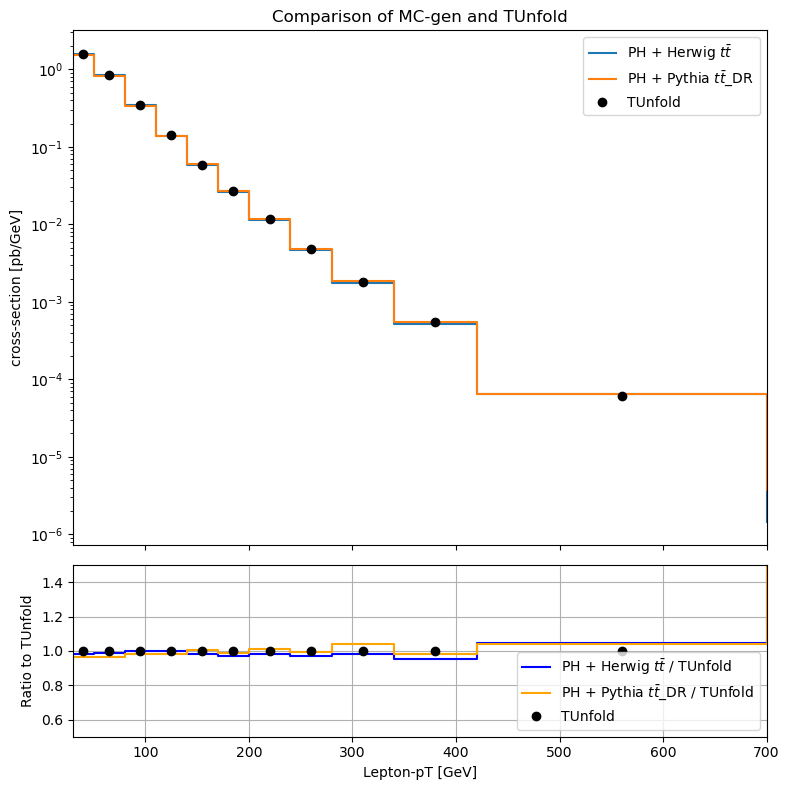

In [34]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF_herwig = (1/luminosity)*1/train_fraction_herwig
SF_pythia = (1/luminosity)*1/train_fraction_pythia
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()


fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)

# --- Bin widths (same for all histograms) ---
bin_widths = np.diff(edges)

# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    herwig_loader.gen[:, 0, 0][herwig_loader.pass_gen], 
    weights=herwig_loader.weight[herwig_loader.pass_gen]*SF_herwig, 
    bins=edges, 
    histtype='step', 
    label='ttbar'
)

counts2, bins2, _ = ax1.hist(
    pythia_loader.gen[:, 0, 0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF_pythia, 
    bins=edges, 
    histtype='step', 
    label='ttbar_DR'
)

# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Herwig $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label=r"PH + Pythia $t\bar{t}$_DR")
ax1.plot(bin_centers[:-1], values_density[:-1], 'o', color='black', label='TUnfold')

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of MC-gen and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Herwig $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label=r"PH + Pythia $t\bar{t}$_DR / TUnfold")
ax2.plot(bin_centers[:-1], ratio3[:-1], 'o', color='black', label='TUnfold')

#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(30,700)
ax2.set_ylim(0.5, 1.5)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 12 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

I0000 00:00:1760340196.587627 2634714 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140838 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [36]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1760427328.760893 3049941 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140838 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [40]:
omnifold = omnifold.MultiFold(
    "WWbb_closure_herwig_to_pythia_ttbar",
    model1, # model_reco
    model2, # model_gen
    pythia_loader, # data
    herwig_loader, # MC
    batch_size = 128,
    niter = 4,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_bulk_closure_Herwig_to_pythia',
    verbose = True,
    lr = 1e-6,
)

31250 training steps at reco and 31250 steps at gen


In [41]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1199342, Test events used: 299836
################################################################################
Epoch 1/100


I0000 00:00:1760427468.453386 3063598 service.cc:152] XLA service 0x7f5aa8014420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760427468.453426 3063598 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-10-14 09:37:48.636164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760427469.422743 3063598 cuda_dnn.cc:529] Loaded cuDNN version 90501


  88/7495 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0866 

I0000 00:00:1760427476.770322 3063598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7495/7495 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0848 - val_loss: 0.0826 - learning_rate: 1.0000e-06
Epoch 2/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0822 - val_loss: 0.0808 - learning_rate: 1.0000e-06
Epoch 3/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0805 - val_loss: 0.0796 - learning_rate: 1.0000e-06
Epoch 4/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0793 - val_loss: 0.0787 - learning_rate: 1.0000e-06
Epoch 5/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0783 - val_loss: 0.0779 - learning_rate: 1.0000e-06
Epoch 6/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0777 - val_loss: 0.0772 - learning_rate: 1.0000e-06
Epoch 7/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0771 - val_loss: 0.0767 - learning_rate: 1.0000e-06
Epoch 8/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0768 - val_loss: 0.0764 - learning_rate: 1.0000e-06
Epoch 9/100
7495/7495 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.07

In [42]:
unfolded_weights  = omnifold.reweight(herwig_truth_test,omnifold.model2,batch_size=1000)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step


In [43]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_bulk_closure_Herwig_to_pythia/unfolded_weights.npy", unfolded_weights)

In [ ]:
#unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_bulk_closure_Herwig_to_pythia_ttbar_DR/unfolded_weights.npy")

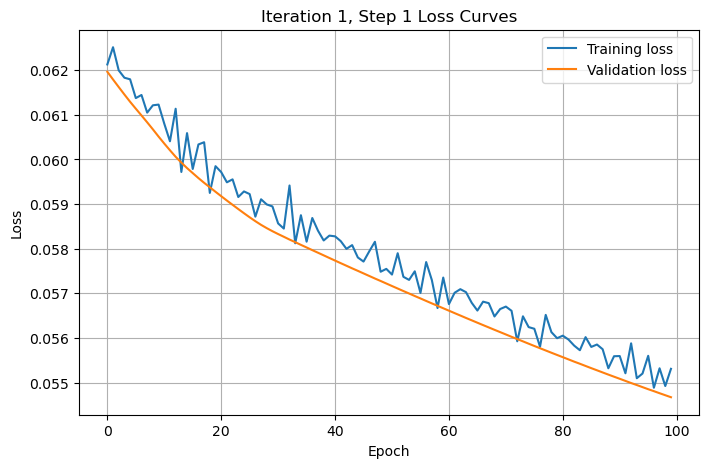

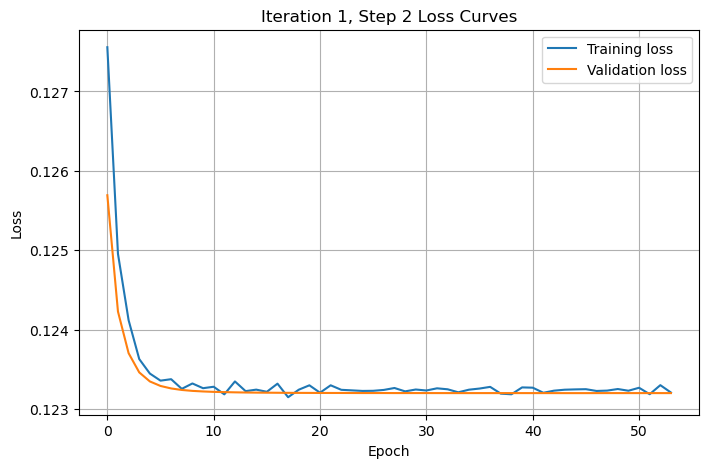

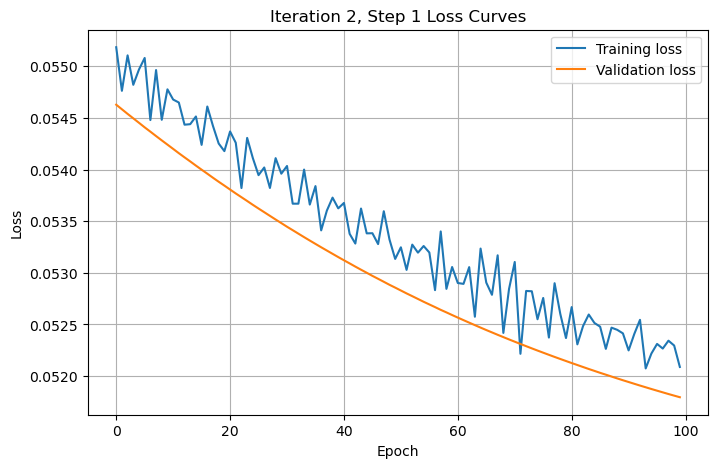

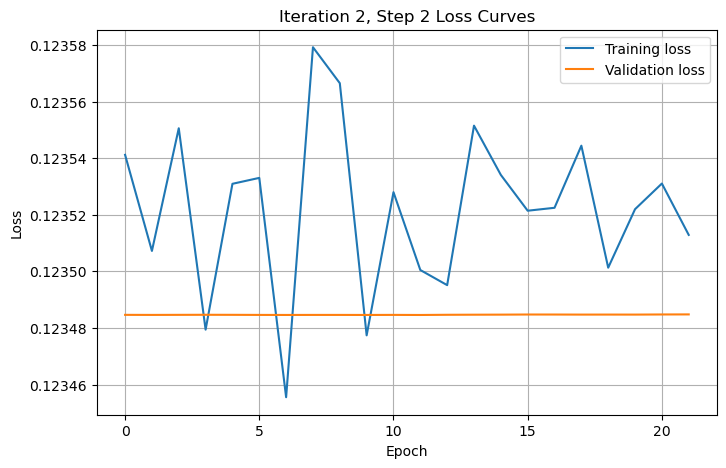

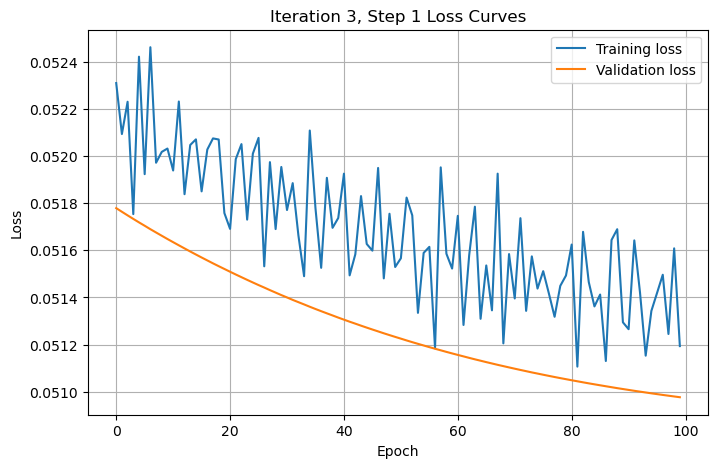

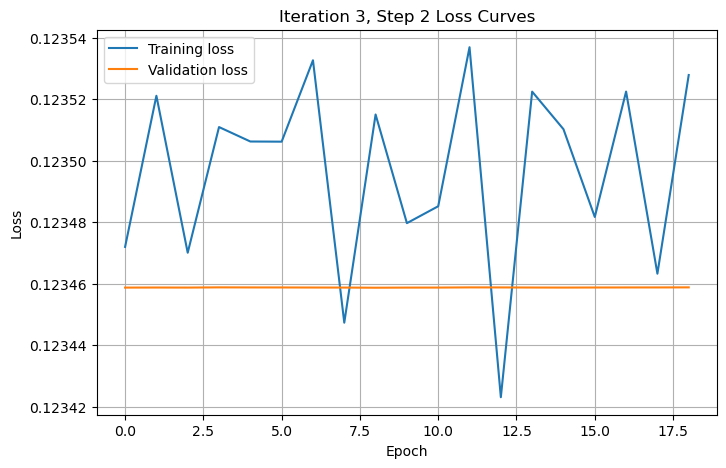

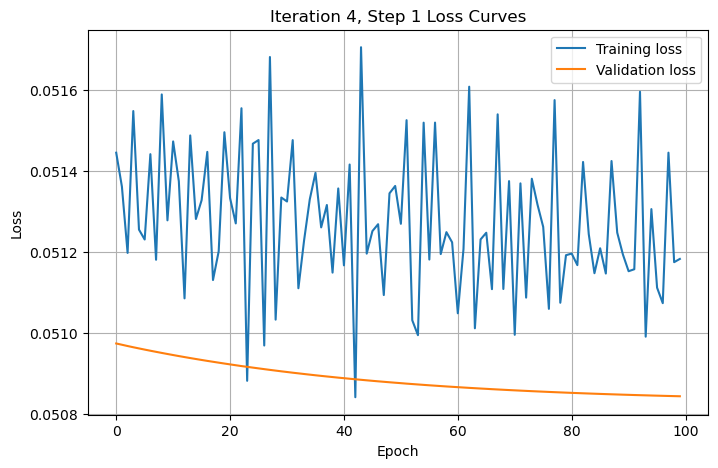

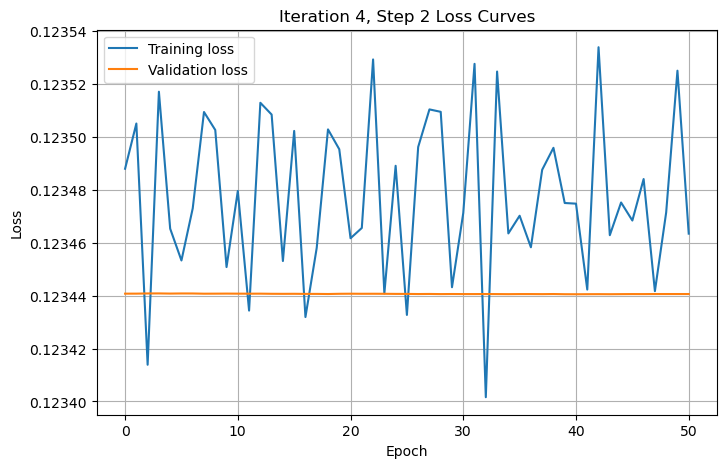

In [44]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_bulk_closure_Herwig_to_pythia_ttbar_DR'      
name = "WWbb_closure_herwig_to_pythia_ttbar_DR"     
niter = 4                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


/scratch/mjosef/Unfolding/omnifold/omnifold/utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 9))


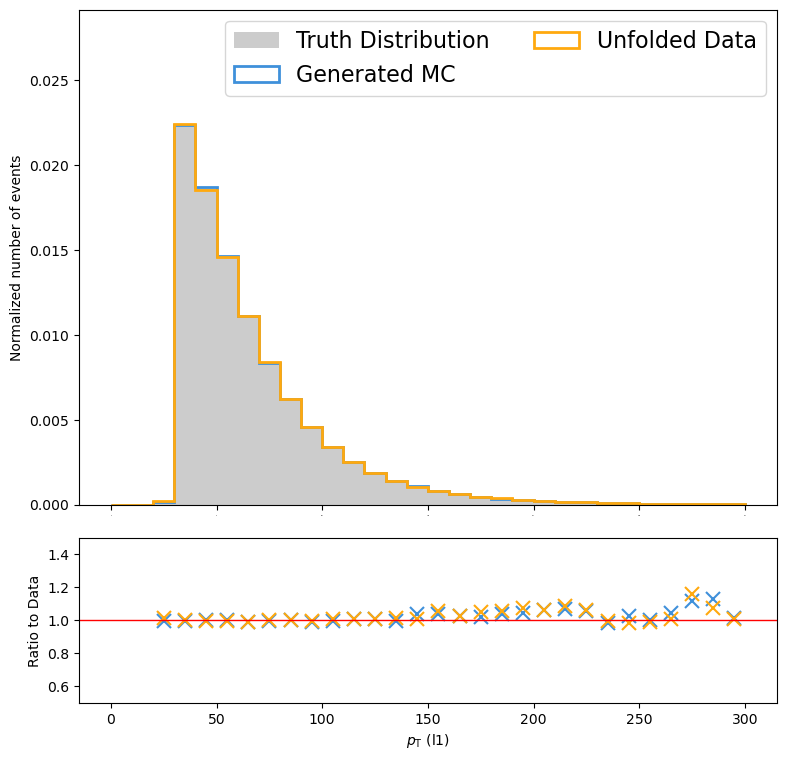

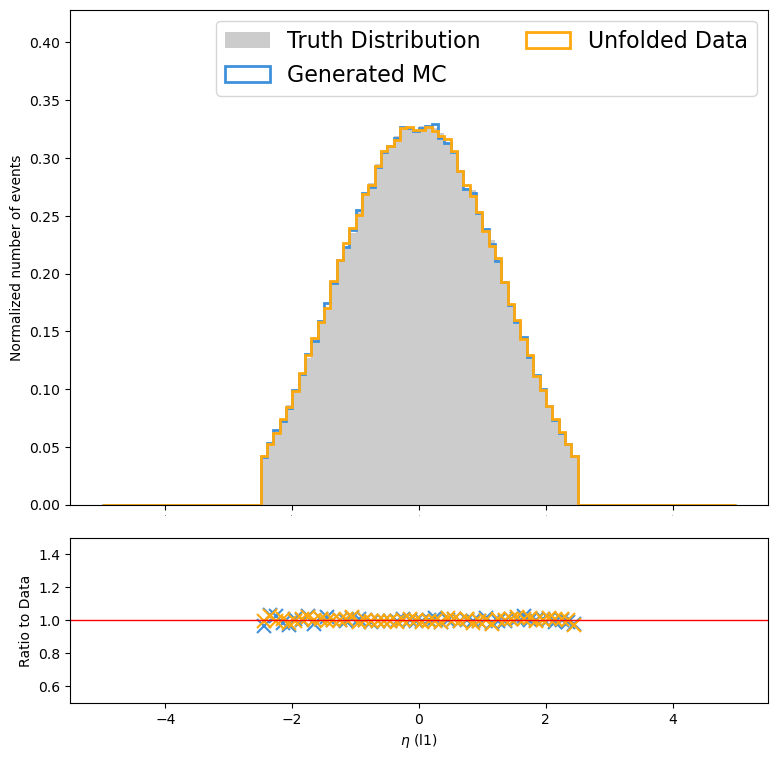

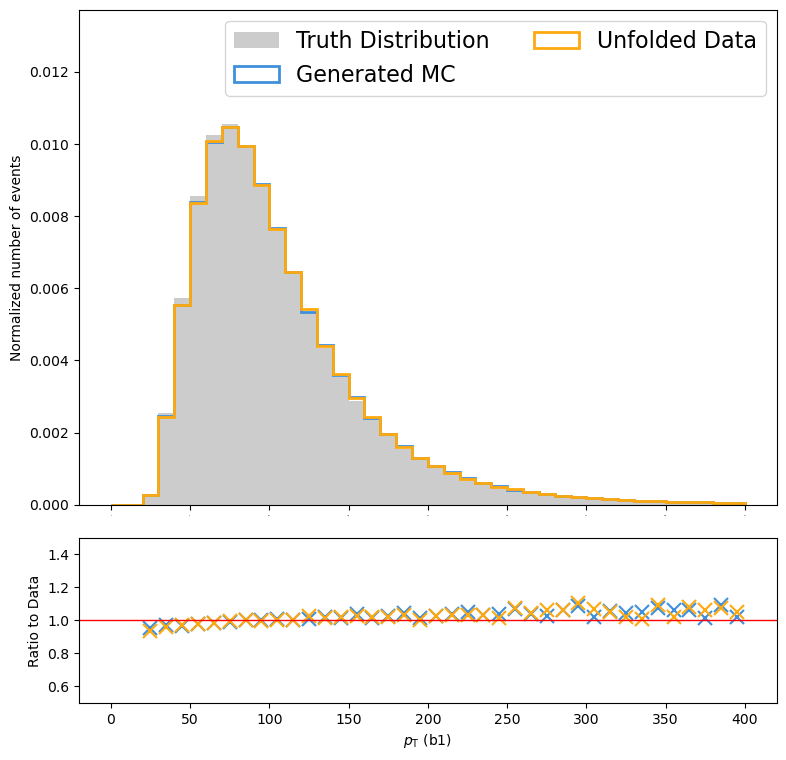

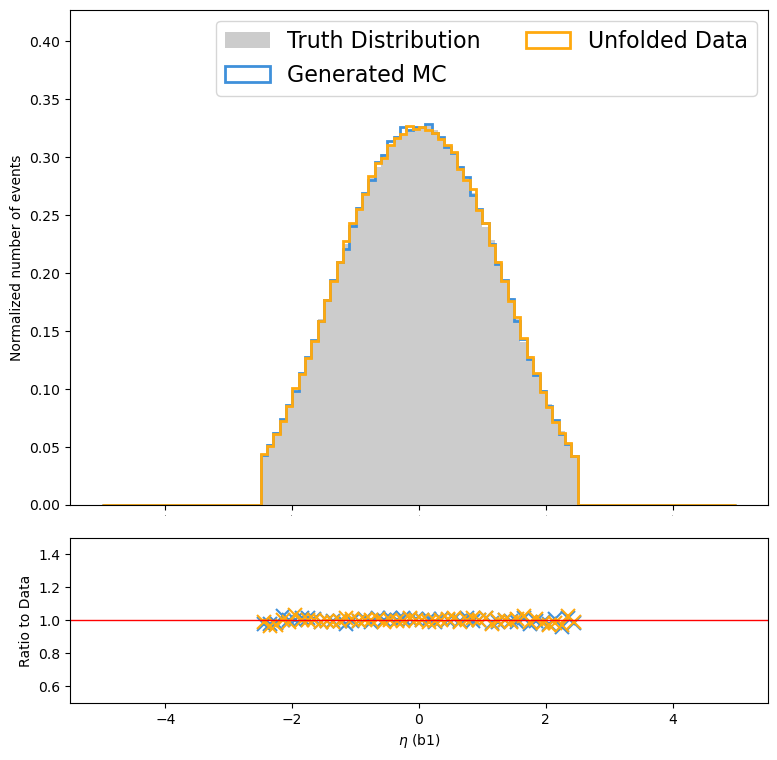

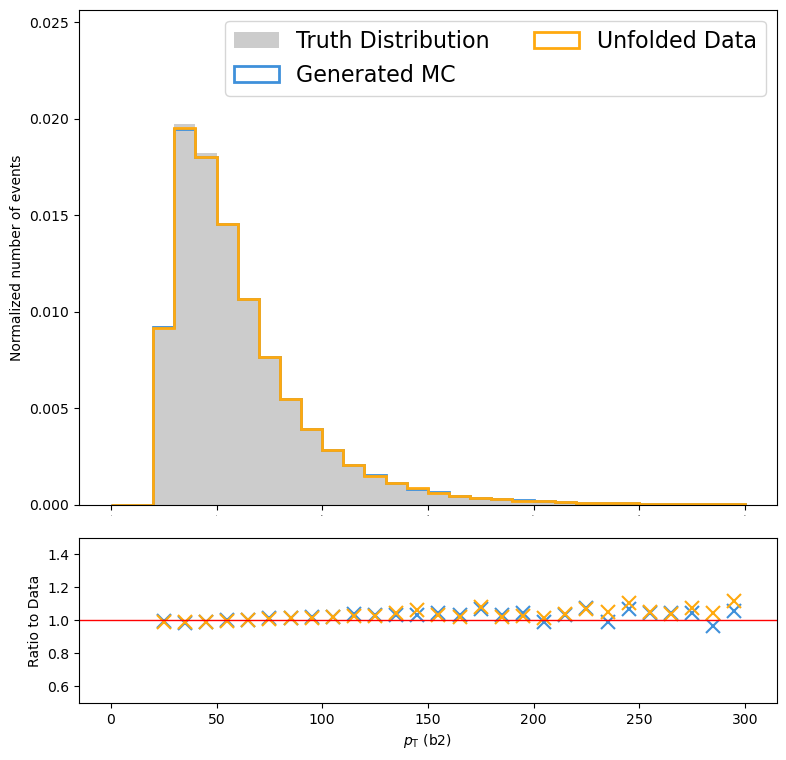

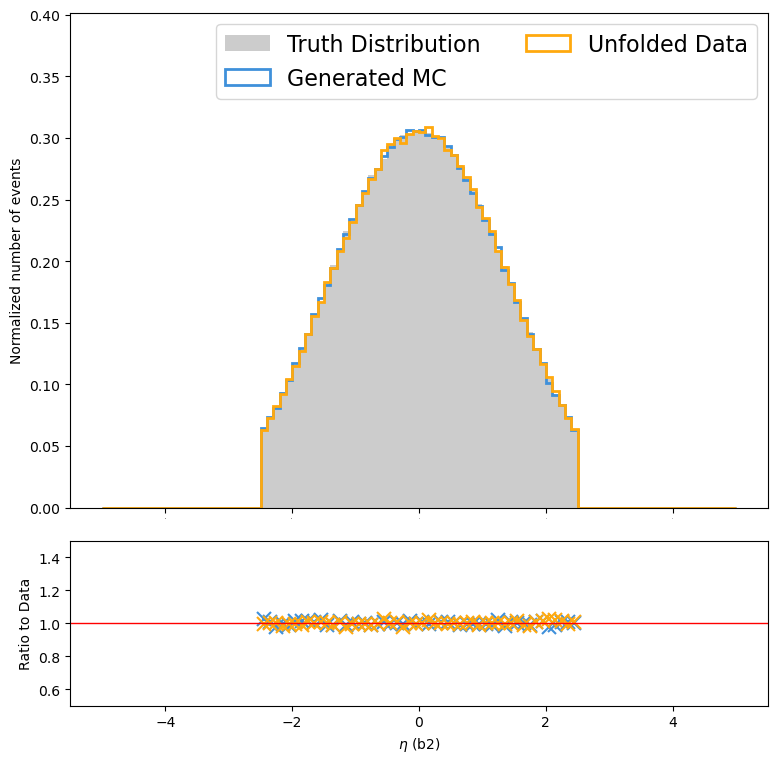

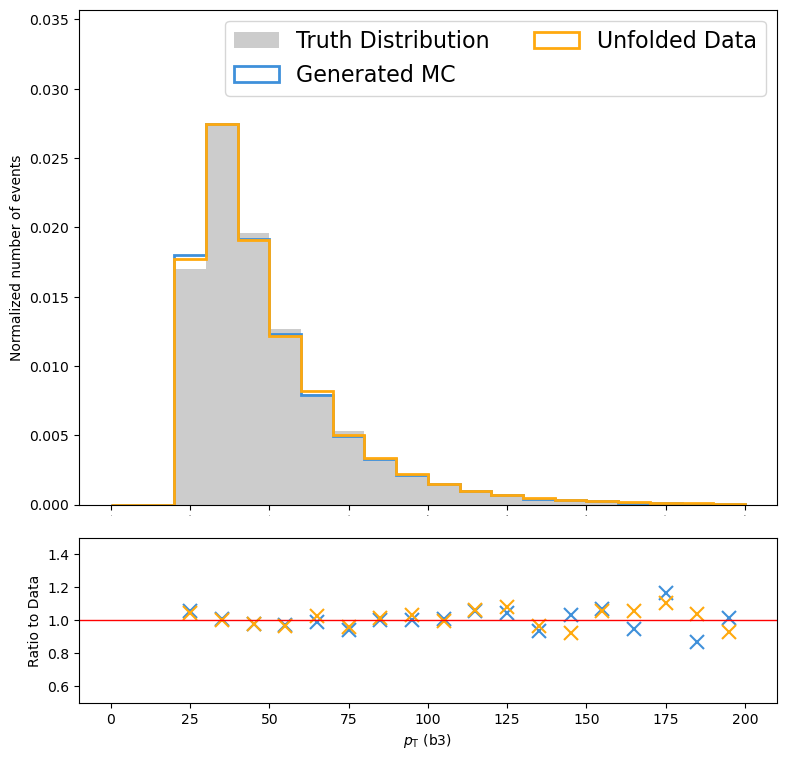

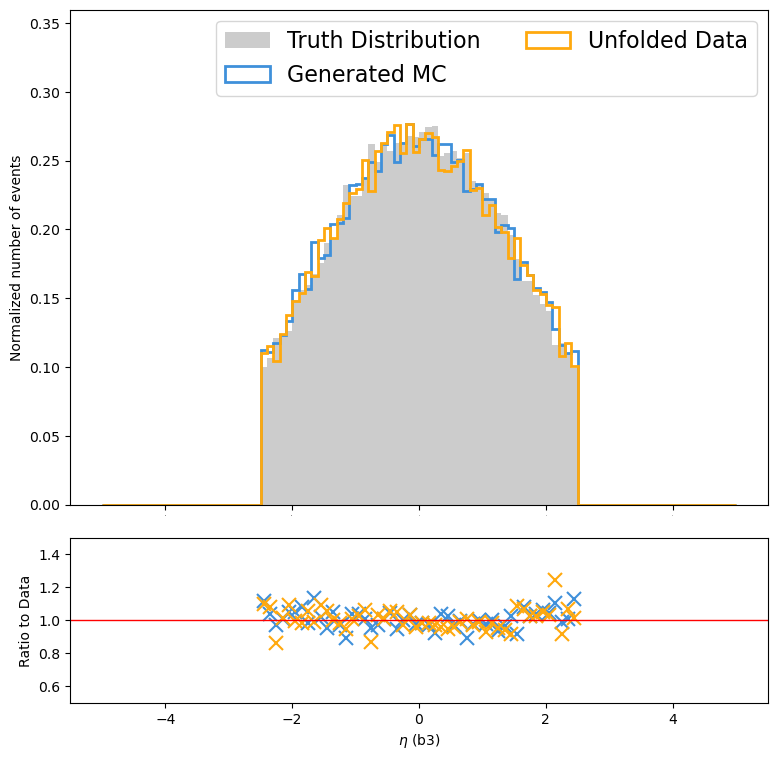

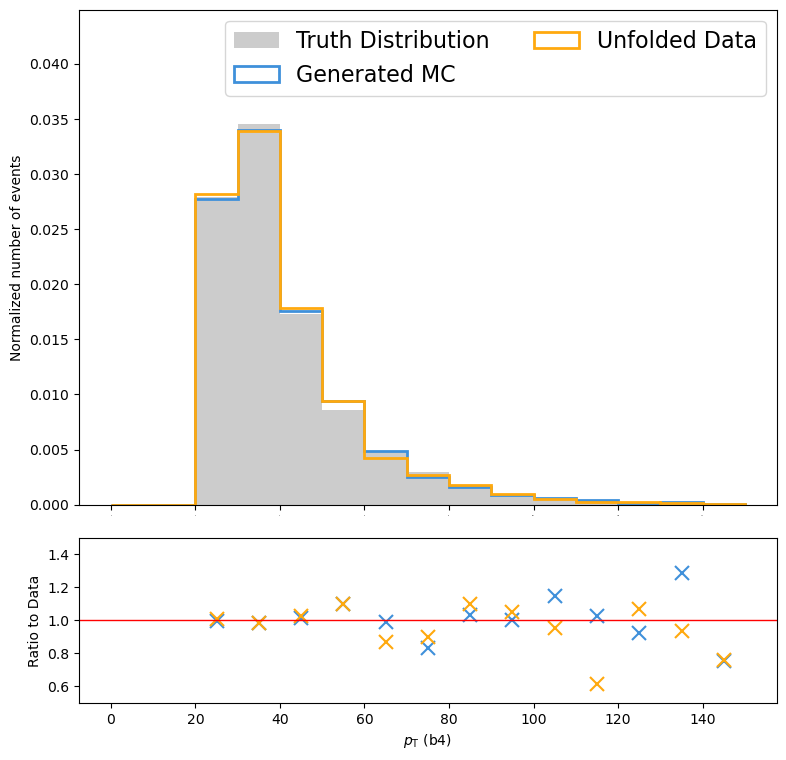

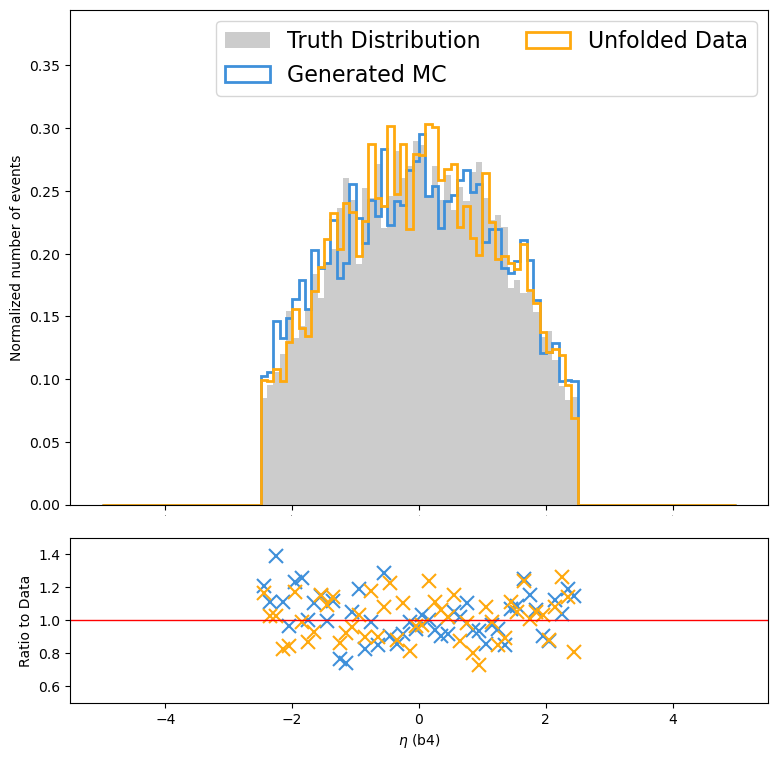

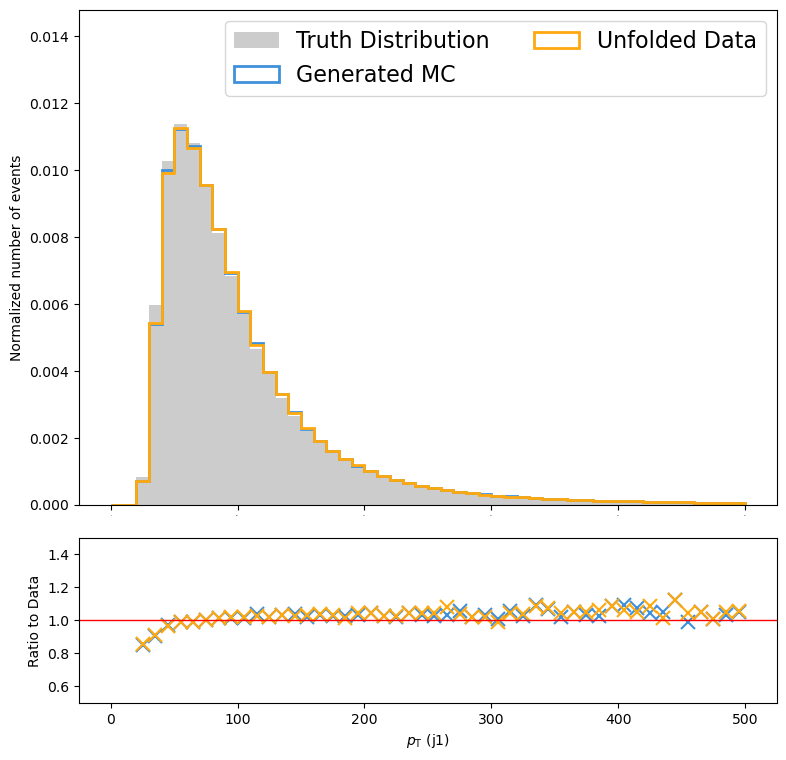

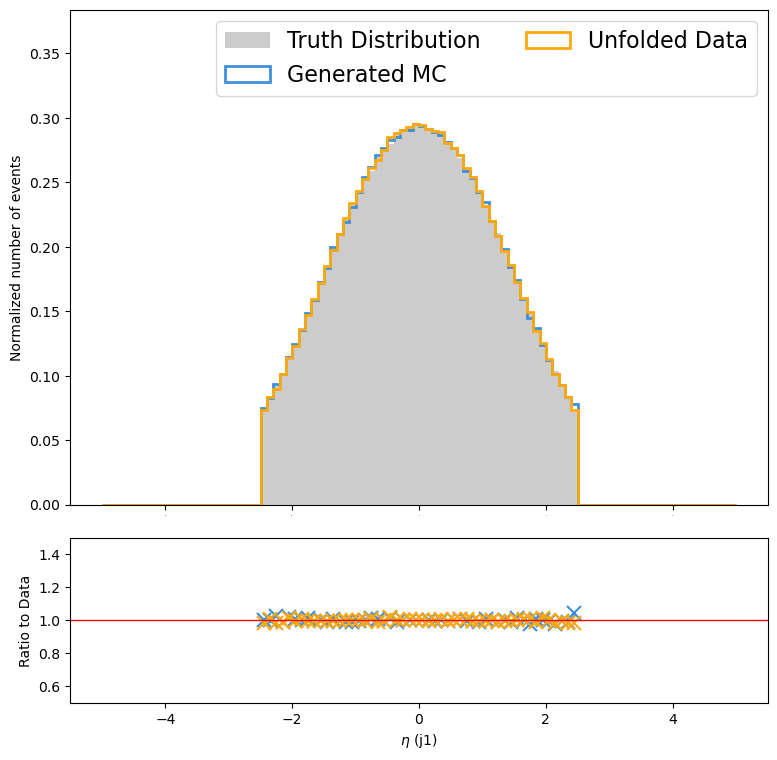

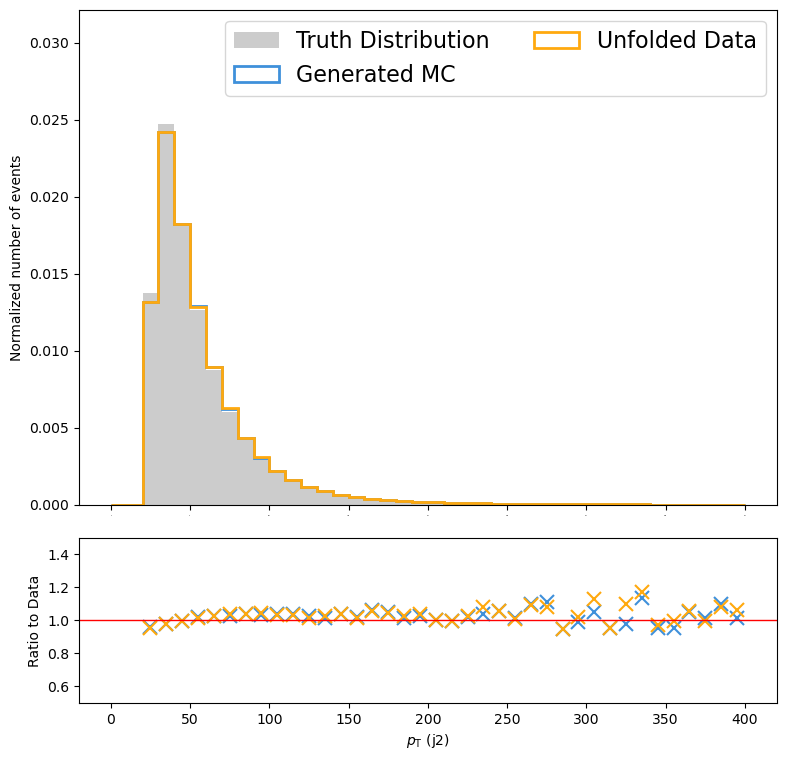

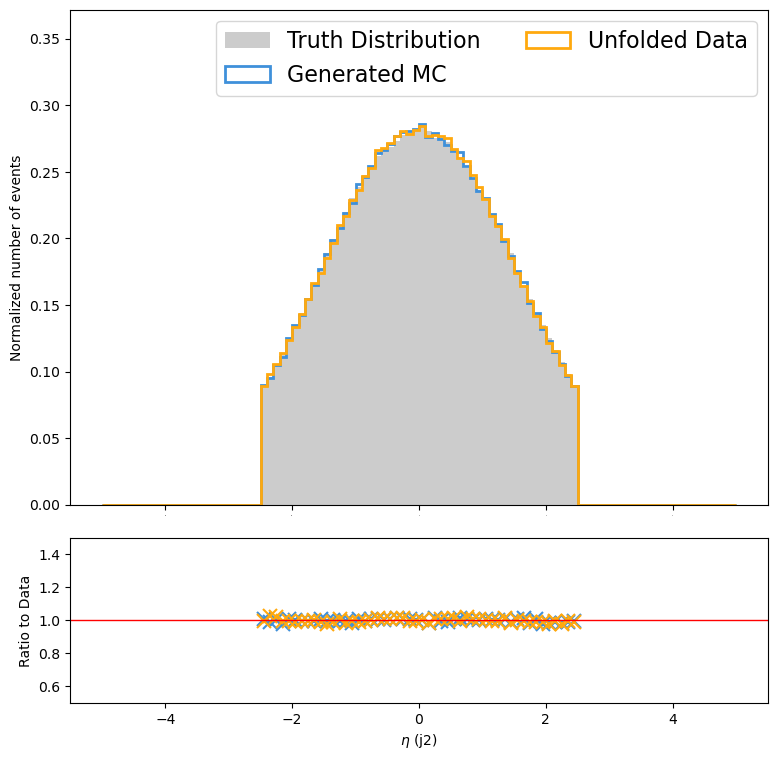

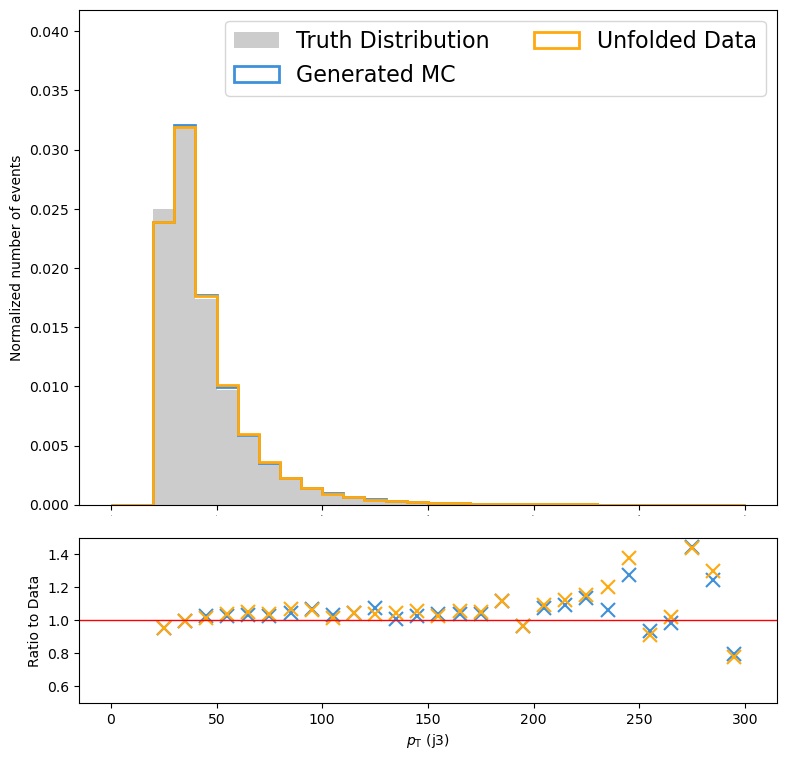

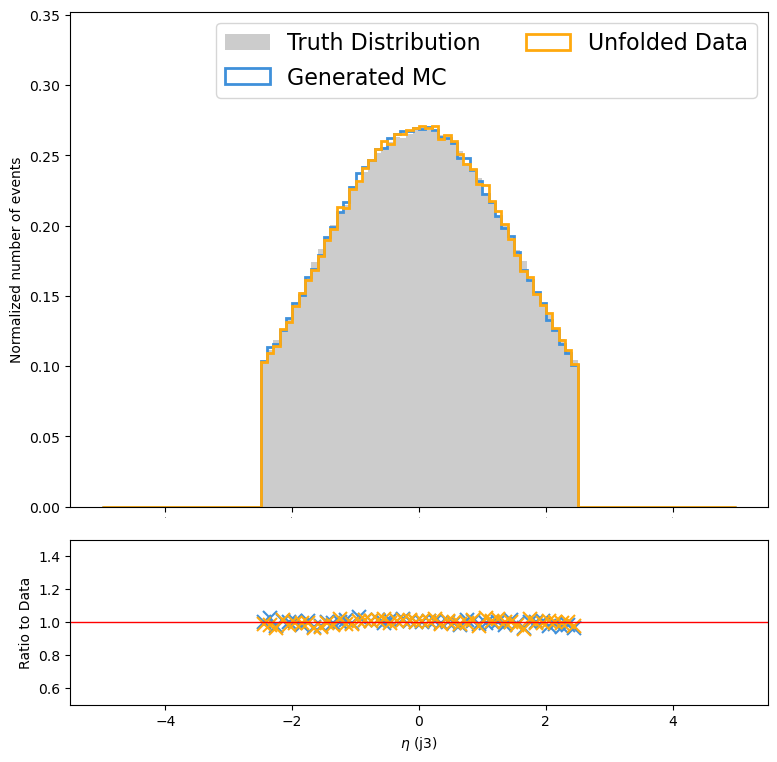

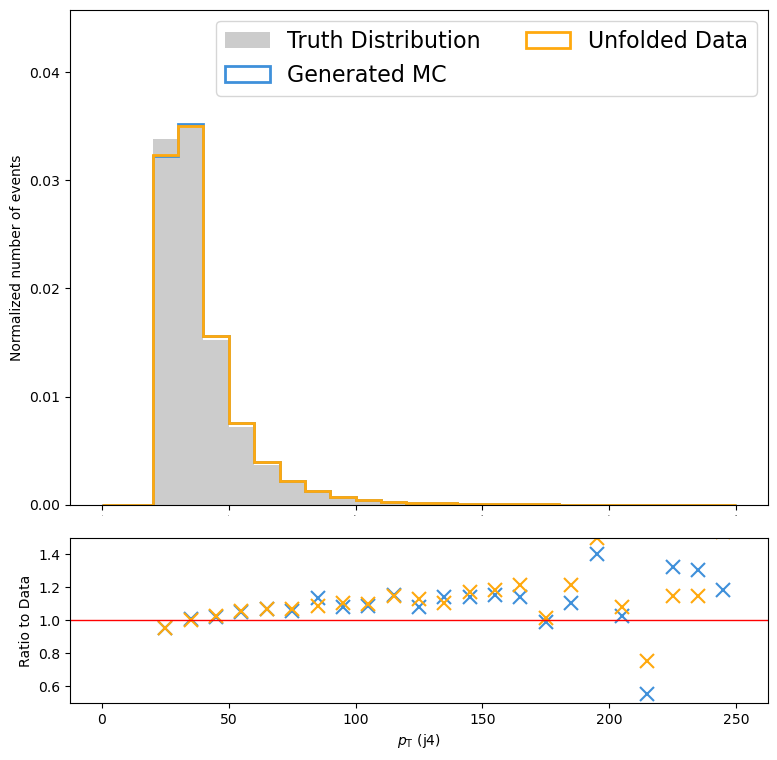

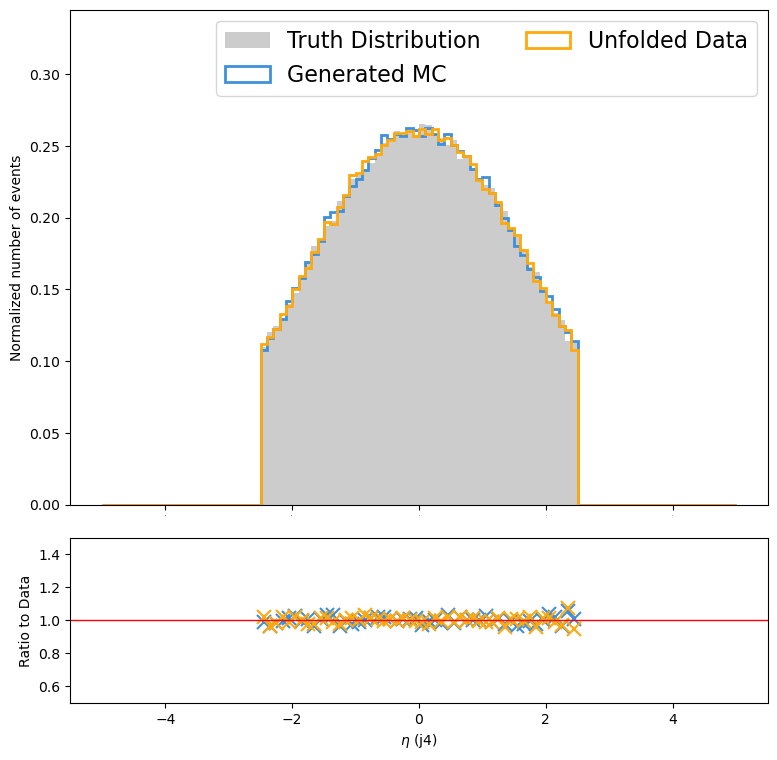

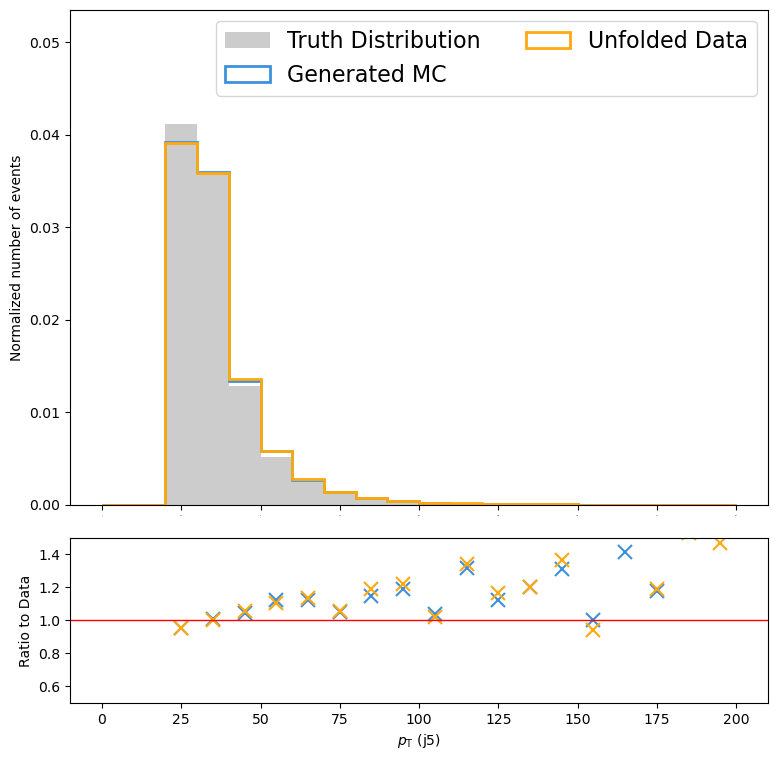

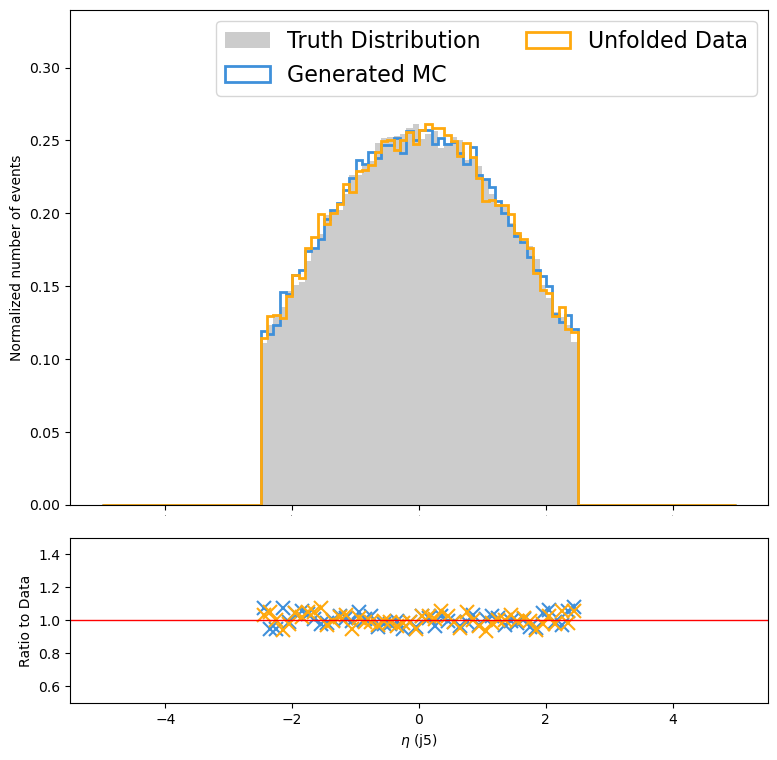

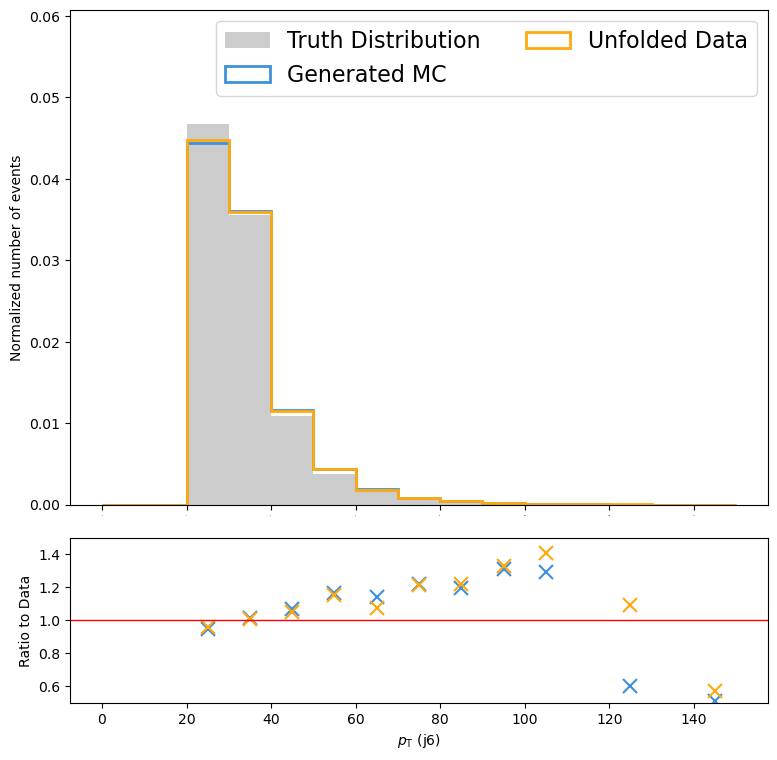

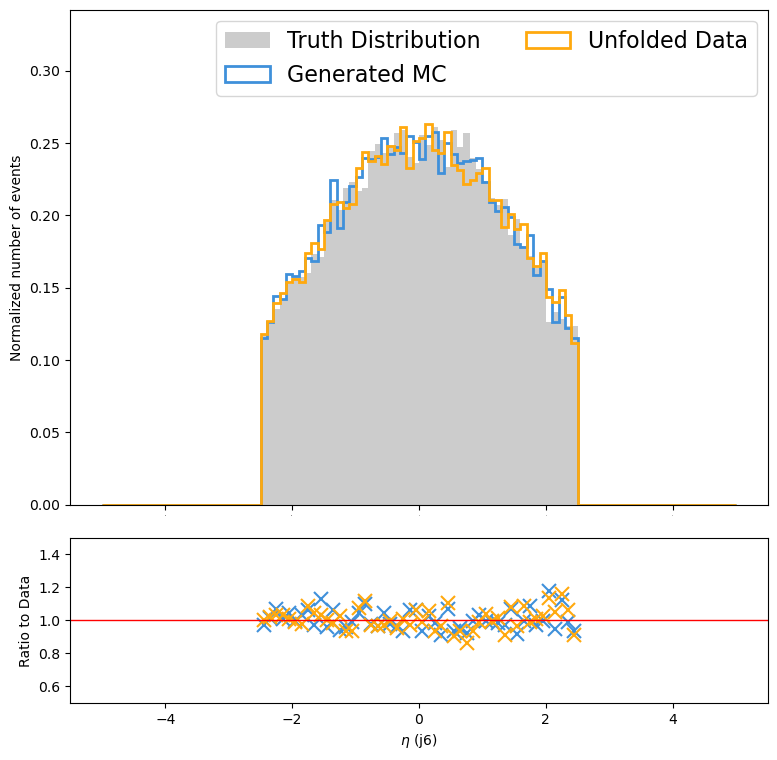

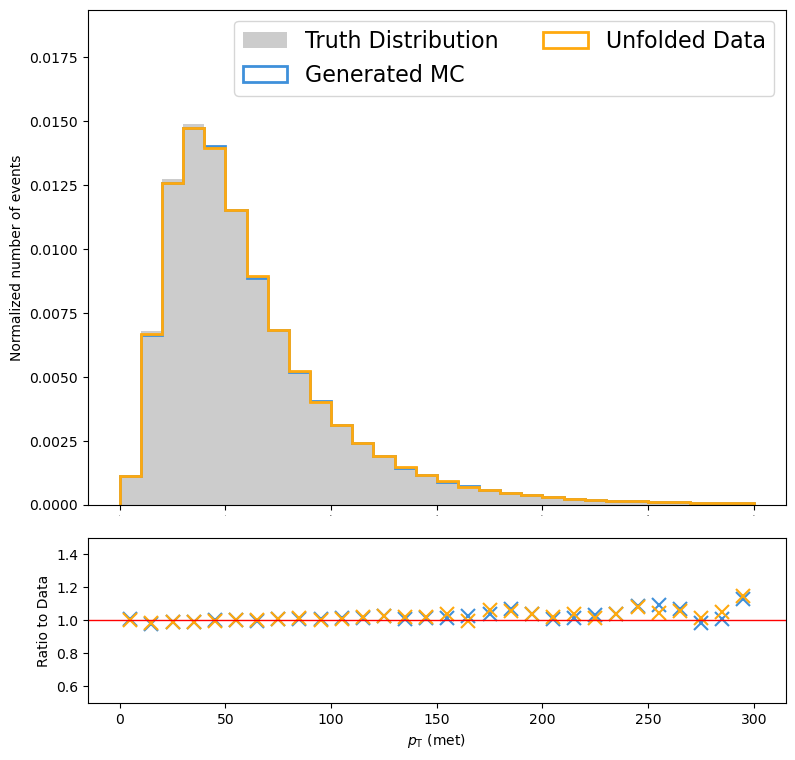

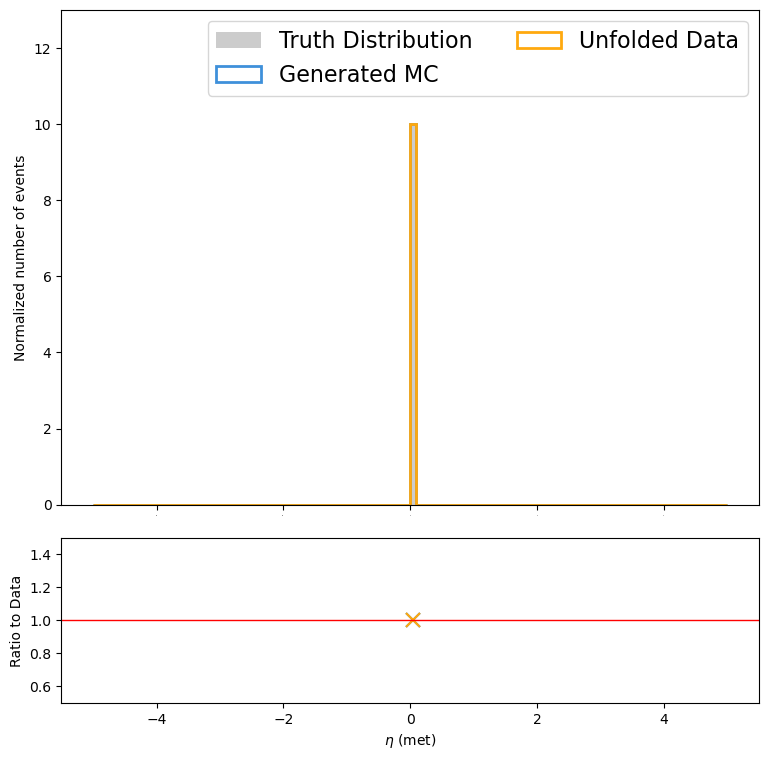

In [45]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 31),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]


for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            'Truth Distribution': herwig_loader.gen[:, i, obs_index][herwig_loader.gen[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.reco[:, i, obs_index][herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.gen[:, i, obs_index][(pythia_loader.gen[:, i, 0]!=0)],
            #'Reconstructed MC': pythia_loader.reco[:, i, obs_index][(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            'Truth Distribution': herwig_loader.weight[herwig_loader.gen[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.weight[herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.weight[(pythia_loader.gen[:, i, 0]!=0)],
            #'Reconstructed MC': pythia_loader.weight[(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': unfolded_weights[pythia_truth_test[:, i, 0]!=0]*pythia_weights_test[pythia_truth_test[:, i, 0]!=0],
        }

        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Truth Distribution',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins,
        )